<a href="https://colab.research.google.com/github/nateraw/vision/blob/main/notebooks/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Vision Transformers for Image Classification

The Vision Transformer (ViT) was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain. 

Here's how they explained it:
> Inspired by the Transformer scaling successes in NLP, we experiment with applying a standard
Transformer directly to images, with the fewest possible modifications. To do so, we split an image
into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer. Image patches are treated the same way as tokens (words) in an NLP application.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)

#### TODO - Add more info on model here

---

In this notebook, we'll walk through how to leverage 🤗 `datasets` to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 `transformers`. 

To get started, lets first install both those packages.

In [35]:
# blocks output in Colab 💄
%%capture

! pip install git+https://github.com/nateraw/transformers.git@fix-model-card-index --upgrade
! pip install datasets

## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the `'beans'` dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 🍃



In [36]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

Couldn't find file locally at /content/beans/beans.py, or remotely at https://raw.githubusercontent.com/huggingface/datasets/1.11.0/datasets/beans/beans.py.
The file was picked from the master branch on github instead at https://raw.githubusercontent.com/huggingface/datasets/master/datasets/beans/beans.py.
Using custom data configuration default
Reusing dataset beans (/root/.cache/huggingface/datasets/beans/default/0.0.0/da16541c9d236f9aba86fb91be1ea9e052c8cd74970ac9beb7fe09830746ce3b)


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'labels'],
        num_rows: 128
    })
})

Image datasets within the `datasets` package often have a feature representing the path to individual image files. Let's look at an example:

In [37]:
ex = ds['train'][0]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/0aaa78294d4bf5114f58547e48d91b7826649919505379a167decb629aa92b0a/train/healthy/healthy_train.25.jpg',
 'labels': 2}

As we can see, `image_file_path` is a path within a cache directory that was created when we downloaded the source dataset.

Lets take that path and open the file as a `PIL` image so we can take a look at it.

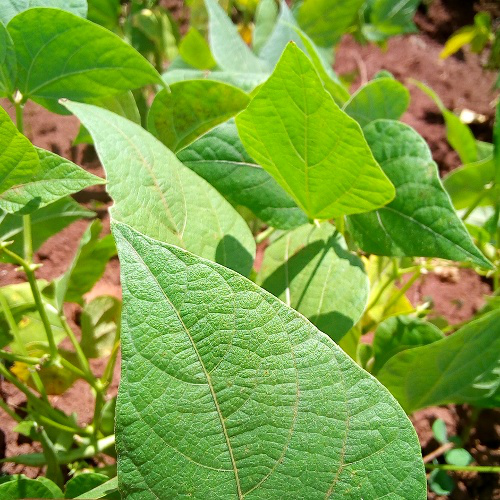

In [38]:
from PIL import Image

def pil_loader(path):
    with open(path, 'rb') as f:
        image = Image.open(f).convert("RGB")
    return image

image = pil_loader(ex['image_file_path'])
image

Thats definitely a leaf! But what kind? 😅

Since the `'labels'` feature of this dataset is a `datasets.features.ClassLabel`, we can use it to lookup the corresponding name for this example's label ID.

First, lets access the feature definition for the `'labels'`.

In [39]:
labels = ds['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], names_file=None, id=None)

Now, lets print out the class label for our example

In [40]:
labels.int2str(ex['labels'])

'healthy'

Turns out the leaf shown above is infected with Angular Leaf Spot, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

Loading cached processed dataset at /root/.cache/huggingface/datasets/beans/default/0.0.0/da16541c9d236f9aba86fb91be1ea9e052c8cd74970ac9beb7fe09830746ce3b/cache-0b44c3ca8dd8656f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/beans/default/0.0.0/da16541c9d236f9aba86fb91be1ea9e052c8cd74970ac9beb7fe09830746ce3b/cache-9c12bb3af8179f74.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/beans/default/0.0.0/da16541c9d236f9aba86fb91be1ea9e052c8cd74970ac9beb7fe09830746ce3b/cache-8794b8747d256aca.arrow


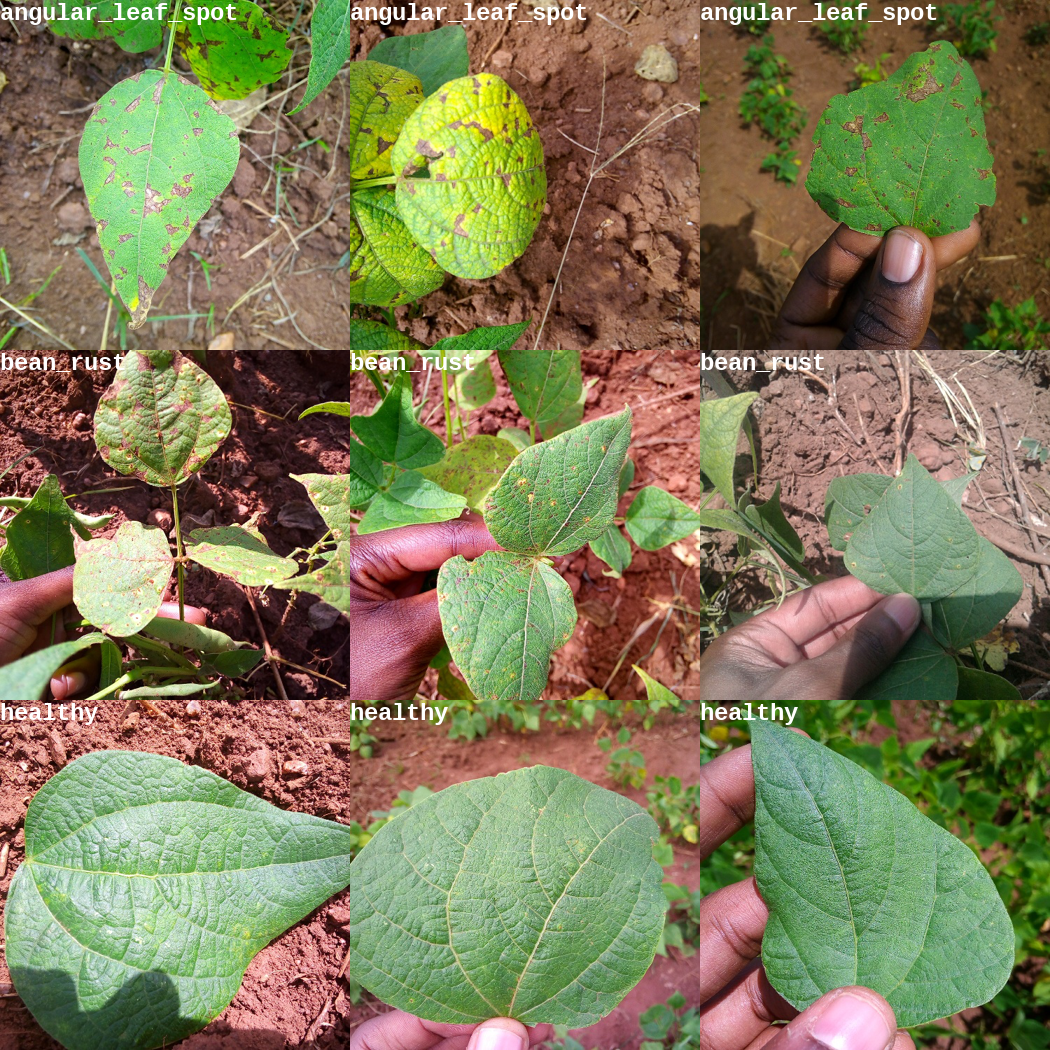

In [41]:
import random
from PIL import ImageDraw, ImageFont

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = pil_loader(example['image_file_path'])
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

From what I'm seeing, 
- Angular Leaf Spot: Has irregular brown patches
- Bean Rust:  Has circular brown spots surrounded with a white-ish yellow ring
- Healthy: ...looks healthy.

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model. 

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a `ViTFeatureExtractor` initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the `google/vit-base-patch16-224-in21k` model, so lets load its feature extractor from the 🤗 Hub.

In [42]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading feature extractor configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/7c7f3e780b30eeeacd3962294e5154788caa6d9aa555ed6d5c2f0d2c485eba18.c322cbf30b69973d5aae6c0866f5cba198b5fe51a2fe259d2a506827ec6274bc
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



If we print a feature extractor, we can see its configuration.

In [43]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

To process an image, simply pass it to the feature extractor's call function. This will return `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [44]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.3647,  0.3647,  0.3804,  ..., -0.7647, -0.7569, -0.7490],
          [ 0.3804,  0.3961,  0.4118,  ..., -0.6157, -0.6706, -0.7176],
          [ 0.2627,  0.3098,  0.3176,  ..., -0.4275, -0.5216, -0.6392],
          ...,
          [-0.4588, -0.4588, -0.5059,  ..., -0.5373, -0.4588, -0.3647],
          [-0.4980, -0.4824, -0.5216,  ..., -0.3490, -0.1922, -0.1765],
          [-0.4980, -0.5137, -0.4824,  ..., -0.4039, -0.3412, -0.4275]],

         [[ 0.7098,  0.7176,  0.7333,  ..., -0.8745, -0.8196, -0.7961],
          [ 0.7412,  0.7569,  0.7725,  ..., -0.7333, -0.7647, -0.8039],
          [ 0.6549,  0.6863,  0.6863,  ..., -0.5922, -0.6627, -0.7647],
          ...,
          [ 0.0824,  0.0745,  0.0118,  ..., -0.7020, -0.6941, -0.6235],
          [ 0.0196,  0.0039, -0.0275,  ..., -0.5294, -0.4588, -0.4667],
          [-0.0275, -0.0902, -0.0588,  ..., -0.5686, -0.5373, -0.6157]],

         [[ 0.4667,  0.4824,  0.5059,  ..., -0.9922, -0.9922, -0.9843],
          [ 0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [45]:
def process_example(example):
    image = pil_loader(example['image_file_path'])
    example.update(feature_extractor(image), return_tensors='pt')
    return example

In [46]:
process_example(ds['train'][0])

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/0aaa78294d4bf5114f58547e48d91b7826649919505379a167decb629aa92b0a/train/healthy/healthy_train.25.jpg',
 'labels': 2,
 'pixel_values': [array([[[ 0.36470592,  0.36470592,  0.3803922 , ..., -0.7647059 ,
           -0.75686276, -0.7490196 ],
          [ 0.3803922 ,  0.39607847,  0.41176474, ..., -0.6156863 ,
           -0.67058825, -0.7176471 ],
          [ 0.26274514,  0.30980396,  0.3176471 , ..., -0.42745095,
           -0.52156866, -0.6392157 ],
          ...,
          [-0.4588235 , -0.4588235 , -0.5058824 , ..., -0.5372549 ,
           -0.4588235 , -0.36470586],
          [-0.4980392 , -0.4823529 , -0.52156866, ..., -0.3490196 ,
           -0.19215685, -0.17647058],
          [-0.4980392 , -0.5137255 , -0.4823529 , ..., -0.40392154,
           -0.34117645, -0.42745095]],
  
         [[ 0.70980394,  0.7176471 ,  0.73333335, ..., -0.8745098 ,
           -0.81960785, -0.79607844],
          [ 0.7411765 ,  0.75686

While we could call `ds.map` and apply this to every example at once, this can be very slow. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [47]:
def transform(example_batch):

    # Read in all the image file paths as PIL images
    images = []
    for path in example_batch.pop('image_file_path'):
        image = pil_loader(path)
        images.append(image)

    # Add pixel values to batch by passing images through the feature extractor
    example_batch.update(feature_extractor(images, return_tensors='pt'))

    return example_batch

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [48]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [49]:
prepared_ds['train'][0:2]

{'labels': [2, 2],
 'pixel_values': tensor([[[[ 0.3647,  0.3647,  0.3804,  ..., -0.7647, -0.7569, -0.7490],
           [ 0.3804,  0.3961,  0.4118,  ..., -0.6157, -0.6706, -0.7176],
           [ 0.2627,  0.3098,  0.3176,  ..., -0.4275, -0.5216, -0.6392],
           ...,
           [-0.4588, -0.4588, -0.5059,  ..., -0.5373, -0.4588, -0.3647],
           [-0.4980, -0.4824, -0.5216,  ..., -0.3490, -0.1922, -0.1765],
           [-0.4980, -0.5137, -0.4824,  ..., -0.4039, -0.3412, -0.4275]],
 
          [[ 0.7098,  0.7176,  0.7333,  ..., -0.8745, -0.8196, -0.7961],
           [ 0.7412,  0.7569,  0.7725,  ..., -0.7333, -0.7647, -0.8039],
           [ 0.6549,  0.6863,  0.6863,  ..., -0.5922, -0.6627, -0.7647],
           ...,
           [ 0.0824,  0.0745,  0.0118,  ..., -0.7020, -0.6941, -0.6235],
           [ 0.0196,  0.0039, -0.0275,  ..., -0.5294, -0.4588, -0.4667],
           [-0.0275, -0.0902, -0.0588,  ..., -0.5686, -0.5373, -0.6157]],
 
          [[ 0.4667,  0.4824,  0.5059,  ..., -0.992

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [50]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the accuracy metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [51]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget.

In [52]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.d319ae673c1dfeefed4e9e154cf674533971813ff9d9a0d5493a88feca5178c8
Model config ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "transformers_version": "4.10.0.dev0"
}

loading weights file https://huggingface.co/google/vit-base-patch16-224-in2

Define training arguments

In [53]:
# Required for push_to_hub=True
! huggingface-cli login
! apt install git-lfs


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: Traceback (most recent call last):
  File "/usr/local/bin/huggingface-cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/huggingface_hub/commands/huggingface_cli.py", line 41, in main
  File "/usr/local/lib/python3.7/dist-packages/huggingface_hub/commands/user.py", line 159, in run
    username = input("Username: ")
KeyboardInterrupt
Reading p

In [54]:
! git config --global user.name "nateraw"
! git config --global user.email "naterawdata@gmail.com"

In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v4",
  group_by_length=True,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  push_to_hub_model_id='vit-base-beans-demo-v4',
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


Now, all instances can be passed to Trainer and we are ready to start training!



In [56]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

## Training

In [57]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 1034
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 130
/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:382: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss


ValueError: ignored

In [32]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =      0.985
  eval_loss               =     0.0645
  eval_runtime            = 0:00:04.41
  eval_samples_per_second =     30.158
  eval_steps_per_second   =      3.855


In [33]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification', 'other-image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to ./vit-base-beans-demo-v3
Configuration saved in ./vit-base-beans-demo-v3/config.json
Model weights saved in ./vit-base-beans-demo-v3/pytorch_model.bin
Configuration saved in ./vit-base-beans-demo-v3/preprocessor_config.json


Upload file pytorch_model.bin:   0%|          | 3.44k/327M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.61k/2.61k [00:00<?, ?B/s]

Upload file runs/Aug27_17-49-35_8aef211896cd/events.out.tfevents.1630086722.8aef211896cd.77.2: 100%|##########…

Upload file runs/Aug27_17-49-35_8aef211896cd/1630086610.446651/events.out.tfevents.1630086610.8aef211896cd.77.…

Upload file runs/Aug27_17-49-35_8aef211896cd/events.out.tfevents.1630086610.8aef211896cd.77.0:  62%|######2   …

The resulting model has been shared to [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans)